In [1]:
!pip install tensorflow-cpu keras numpy pandas matplotlib seaborn opencv-python scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.8/251.8 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 79.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.19.0 which is incompatible.


In [2]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow is built with CUDA: {tf.test.is_built_with_cuda()}")
print(f"GPUs available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
TensorFlow is built with CUDA: False
GPUs available: []


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import cv2

In [6]:
!rm -f /content/dataset.zip

In [7]:
!unzip /content/dataset.zip -d /content/

Archive:  /content/dataset.zip
   creating: /content/dataset/
   creating: /content/dataset/cataract/
  inflating: /content/dataset/cataract/0_left.jpg  
  inflating: /content/dataset/cataract/103_left.jpg  
  inflating: /content/dataset/cataract/1062_right.jpg  
  inflating: /content/dataset/cataract/1083_left.jpg  
  inflating: /content/dataset/cataract/1084_right.jpg  
  inflating: /content/dataset/cataract/1102_left.jpg  
  inflating: /content/dataset/cataract/1102_right.jpg  
  inflating: /content/dataset/cataract/1115_left.jpg  
  inflating: /content/dataset/cataract/1126_right.jpg  
  inflating: /content/dataset/cataract/112_right.jpg  
  inflating: /content/dataset/cataract/1144_left.jpg  
  inflating: /content/dataset/cataract/1144_right.jpg  
  inflating: /content/dataset/cataract/1164_left.jpg  
  inflating: /content/dataset/cataract/1167_right.jpg  
  inflating: /content/dataset/cataract/119_left.jpg  
  inflating: /content/dataset/cataract/1285_left.jpg  
  inflating: /con

In [8]:
!ls /content/dataset/

cataract  diabetic_retinopathy	glaucoma  normal


In [13]:
#  Configuration
DATA_DIR = 'dataset'
NUM_CLASSES = 4
CLASS_NAMES = ['normal', 'cataract', 'glaucoma', 'diabetic_retinopathy']


In [37]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 50
DATA_DIR = 'dataset'
NUM_CLASSES = 4
CLASS_NAMES = ['normal', 'cataract', 'glaucoma', 'diabetic_retinopathy']

# Function to load images and labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            # Read image using OpenCV
            img = cv2.imread(img_path)
            if img is not None:
                # Resize image
                img = cv2.resize(img, IMAGE_SIZE)
                # Normalize pixel values to [0, 1]
                img = img / 255.0
                images.append(img)
                labels.append(label)
            else:
                print(f"Warning: Could not read image {img_path}")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images, labels

all_images = []
all_labels = []

# Load images for each class
for class_name in CLASS_NAMES:
    folder_path = os.path.join(DATA_DIR, class_name)
    if os.path.exists(folder_path):
        print(f"Loading images from: {folder_path}")
        images, labels = load_images_from_folder(folder_path, class_name)
        all_images.extend(images)
        all_labels.extend(labels)
    else:
        print(f"Error: Directory not found for class '{class_name}': {folder_path}")
        print("Please ensure your dataset is structured as 'dataset/normal', 'dataset/cataract', etc.")
        continue

if not all_images:
    print("No images loaded. Please ensure your 'dataset' folder is correctly uploaded or mounted and subfolder names match casing.")
    exit()


Loading images from: dataset/normal
Loading images from: dataset/cataract
Loading images from: dataset/glaucoma
Loading images from: dataset/diabetic_retinopathy


In [38]:
X = np.array(all_images)
y_labels = np.array(all_labels)

print(f"Total images loaded: {len(X)}")
print(f"Shape of image data (X): {X.shape}")
print(f"Shape of labels (y_labels): {y_labels.shape}")


Total images loaded: 4217
Shape of image data (X): (4217, 128, 128, 3)
Shape of labels (y_labels): (4217,)


In [39]:
# Encode labels to numerical format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)
print(f"Encoded labels: {y[:5]} (e.g., {label_encoder.inverse_transform(y[:5])})")
print(f"Classes mapping: {list(label_encoder.classes_)}")

Encoded labels: [3 3 3 3 3] (e.g., ['normal' 'normal' 'normal' 'normal' 'normal'])
Classes mapping: [np.str_('cataract'), np.str_('diabetic_retinopathy'), np.str_('glaucoma'), np.str_('normal')]


In [40]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split into X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Labels split into y_train: {y_train.shape}, y_test: {y_test.shape}")

Data split into X_train: (3373, 128, 128, 3), X_test: (844, 128, 128, 3)
Labels split into y_train: (3373,), y_test: (844,)


In [41]:
# Data Augmentation for Image Data

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [42]:
# Fit data generator to training data
datagen.fit(X_train)

In [43]:
# Build the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout for regularization
    Dense(NUM_CLASSES, activation='softmax') # Output layer with NUM_CLASSES neurons for classification
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Train the Model
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 85s 783ms/step - accuracy: 0.3377 - loss: 1.3375 - val_accuracy: 0.5261 - val_loss: 1.1125
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 781ms/step - accuracy: 0.4648 - loss: 1.1754 - val_accuracy: 0.5723 - val_loss: 1.0601
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 81s 761ms/step - accuracy: 0.4829 - loss: 1.1337 - val_accuracy: 0.5841 - val_loss: 1.0035
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 777ms/step - accuracy: 0.5054 - loss: 1.1136 - val_accuracy: 0.5924 - val_loss: 0.9739
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 84s 787ms/step - accuracy: 0.5439 - loss: 1.0590 - val_accuracy: 0.5865 - val_loss: 0.9761
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 771ms/step - accuracy: 0.5845 - loss: 0.9630 - val_accuracy: 0.5770 - val_loss: 1.0739
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 770ms/step - accuracy: 0.6179 - loss: 0.9243 - val_accuracy: 0.5877 - val_loss: 1.0252
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 783ms/step - accuracy: 0.5945 - loss: 0

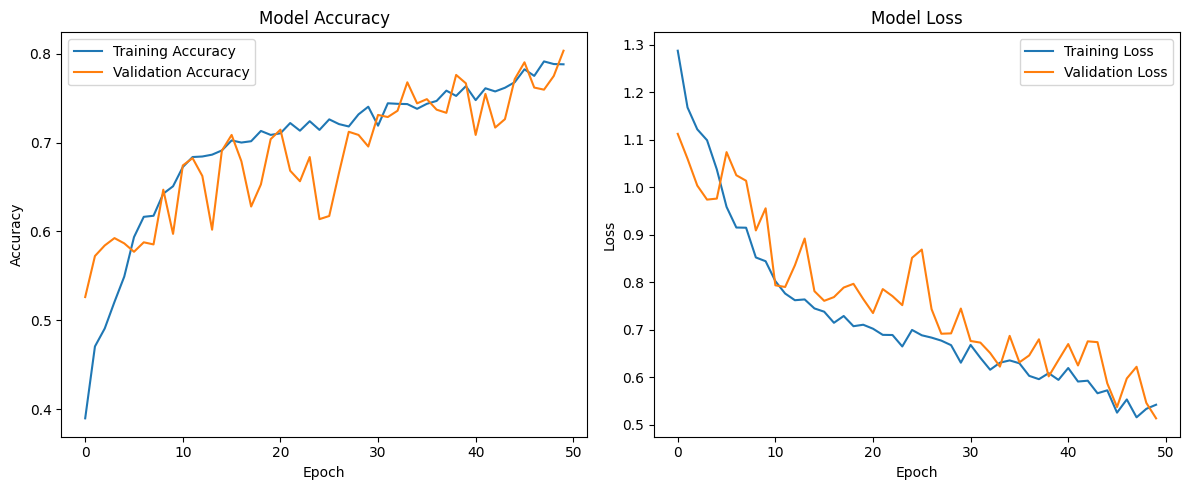

In [45]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


Test Loss: 0.5131
Test Accuracy: 0.8033
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step


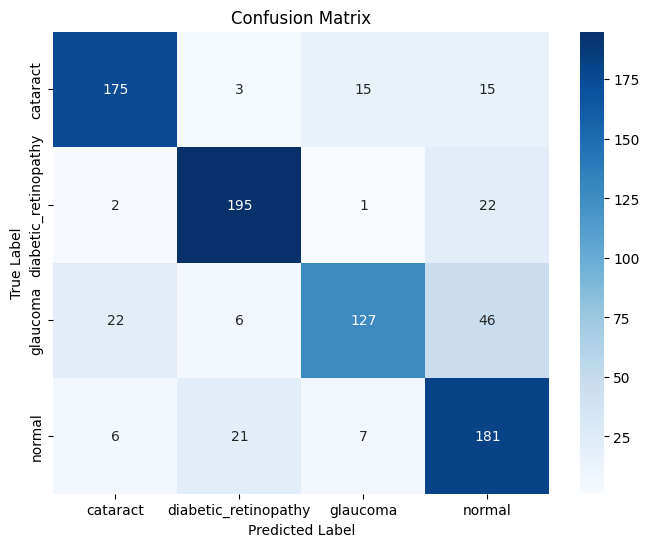


Confusion Matrix:
 [[175   3  15  15]
 [  2 195   1  22]
 [ 22   6 127  46]
 [  6  21   7 181]]

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.85      0.84      0.85       208
diabetic_retinopathy       0.87      0.89      0.88       220
            glaucoma       0.85      0.63      0.72       201
              normal       0.69      0.84      0.76       215

            accuracy                           0.80       844
           macro avg       0.81      0.80      0.80       844
        weighted avg       0.81      0.80      0.80       844



In [46]:
#Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print("\nConfusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Sample Image True Label: diabetic_retinopathy
Sample Image Predicted Label: diabetic_retinopathy
Prediction Probabilities: [5.3978070e-05 9.3720210e-01 1.5249074e-02 4.7494896e-02]


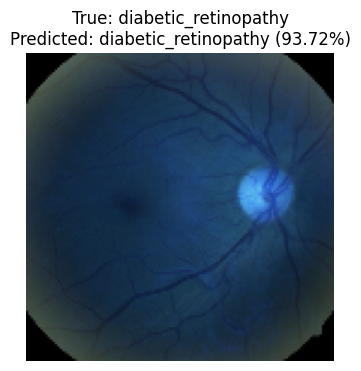

In [47]:
#  Demonstrate Prediction on a Sample Image
sample_index = np.random.randint(0, len(X_test))
sample_image = X_test[sample_index]
true_label_encoded = y_test[sample_index]
true_label_name = label_encoder.inverse_transform([true_label_encoded])[0]

# Reshape for model prediction (add batch dimension)
sample_image_for_prediction = np.expand_dims(sample_image, axis=0)

# Make prediction
prediction_proba = model.predict(sample_image_for_prediction)[0]
predicted_label_encoded = np.argmax(prediction_proba)
predicted_label_name = label_encoder.inverse_transform([predicted_label_encoded])[0]

print(f"Sample Image True Label: {true_label_name}")
print(f"Sample Image Predicted Label: {predicted_label_name}")
print(f"Prediction Probabilities: {prediction_proba}")

# Display the sample image
plt.figure(figsize=(4, 4))
plt.imshow(sample_image)
plt.title(f"True: {true_label_name}\nPredicted: {predicted_label_name} ({prediction_proba[predicted_label_encoded]*100:.2f}%)")
plt.axis('off')
plt.show()